# Inlämningsuppgift: Del 2 - Adversarial input attack

Simon Bengtsson \
sibe19@student.bth.se

Tobias Holm \
toho19@student.bth.se

# Instruktioner

Ändra notebookens platshållare så som era namn- och mailuppgifter samt instruktioner i de olika avsnitten. 

Notebookens underrubriker på nivå 3 (###) är bara ett enkelt exempel på hur er implementation kan delas upp. Ni bör skapa egna rubriker anpassade efter er implementation men lämna alla nivå 1 (#) och 2-rubriker (##) som de är. En viktig del inom data-science är att kunna presentera sina metoder och resultat på ett tydligt sätt. **En ostrukturerad och otydlig notebook kan påverka betygsättningen.**

Notera att t.ex. hyperparameter-tuning och annan optimisering för prestanda inte är nödvändigt i denna uppgift. Så länge modellen fungerar märkvärt bättre än ett "coin flip" så räcker det att ni väljer era hyperparametrar manuellt.

# Uppgiften

Uppgiften går ut på att göra så att bilden på koalan nedan klassificeras som en traktor istället. Givetvis ska bilden på koalan se helt oförändrad ut för det mänskliga ögat då attacken är genomförd. Nedan följer Pythonkod som läser in de båda bilderna som uppgiften bygger på samt läser in en ResNet50-modell som klassiciferar bilderna. Saknar ni några Python-paket, t.ex. TensorFlow så installera dem med en pakethanterarare, t.ex. pip

## Beskrivning av adversarial input attacker

Börja med att förklara vad denna typ av attacker är och hur de fungerar i rapportens sektion 2.1.

Den simplaste adverserial input attacken är en så kallad noice-Den simplaste adverserial input attacken är en så kallad "noise attack" där man tar en original bild som modell f klassifiserar som x1, och lägger till ett slumpvalt antal pixlar som förvränger varje pixels r/g/b värden i mening av att förvirra modell f att klassificera bilden som något annat än x1. Detta är en untargeted attack metod dvs att man ej kan använda den för att klassificera en originabild x1 som x2, utan enbart som någonting som ej är x1, eller tillockmed fortfarande x1 om f är tränad på förvrängda bilder för att motverka just dessa typer av attacker.

Den mest "rak på sak" försvars metoden är som sagt innan att förvränga sin egen träningsdata och låta sin modell f tränas på den på samma sätt som original o-förvrängda träningsdatan. Detta görs i avsikt att göra modellen mer robust och förstärka dens förmåga att generalisera input data och minska risken för "over-fitting" där modellen är beroende på ett litet subset av v från träningssetets exempel för det att klassifiera.

Dessa bå blivit överträffade med mer dynamiska metoder som både är targeted, dvs att användaren av attacken kan välja vilken klassificering hen vill att den pertuberade x1 ska få. Nya metoder har också fokuserat ljupare in på att göra pertubationen svårare och svårare att känna igen, både för mänskliga ögat, men också för olika försvarsmetoder. Allt som allt är båda dessa metoder fortfarande grundläggande för att förstå de senaste metodiken och forskningen i området, och därför en bra och simpel start.da metoder är så grundläggande som går, och har i dagens fall

## Nedan följer kod för att läsa in bilderna och klassificera dem med ResNet50 modellen

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

tf.compat.v1.disable_eager_execution()

print(f"TensorFlow: {tf.__version__}")

e:\Programmering\DV2607 Säkerhet i AI-system\DV2607-data-poisoning\Part2\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\Programmering\DV2607 Säkerhet i AI-system\DV2607-data-poisoning\Part2\venv\lib\site-packages\art\estimators\certification\__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


TensorFlow: 2.11.0


In [2]:
# Loads the pretrained ResNet50 model
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
102967424/102967424 [==============================] - 1s 0us/step


In [3]:
# Load the two images (koala & tractor)
init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)

target_image = image.load_img("images/tractor.jpeg", target_size=(224, 224))
target_image = image.img_to_array(target_image)

class_lookup = {105: "koala", 866: "tractor"}

e:\Programmering\DV2607 Säkerhet i AI-system\DV2607-data-poisoning\Part2\venv\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Init image class label: 105 (koala)


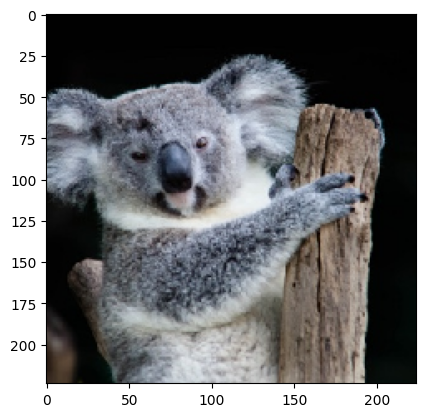

Target image class label: 866 (tractor)


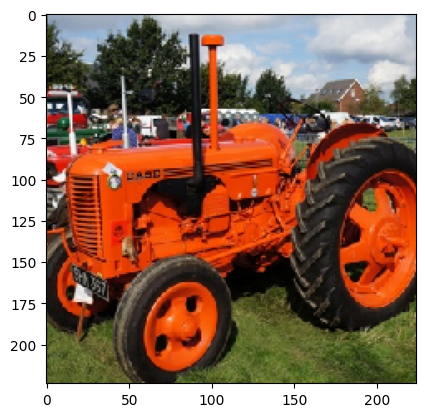

In [4]:
init_class_id = np.argmax(model.predict(np.array([init_image])))
print(f"Init image class label: {init_class_id} ({class_lookup[init_class_id]})")
plt.imshow(init_image.astype(np.uint))
plt.show()

target_class_id = np.argmax(model.predict(np.array([target_image])))
print(f"Target image class label: {target_class_id} ({class_lookup[target_class_id]})")
plt.imshow(target_image.astype(np.uint))
plt.show()

## Implementation av er attack

Beskriv i er rapport vad just er valda attack kallas och i detalj hur den fungerar (sektion 2.2 i rapporten). Beskriv även kort vilka bibliotek ni använder för att implementera den.

## Er kod för attacken

I cellerna nedan lägger ni in er egen kod för att genomföra attacken.

### Bibliotek

In [110]:
# Samla era import statements här e.g.
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image as im

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
# ...

### Egna funktioner

In [15]:
# Samla era egna funktioner relaterade till attacken här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil

### Förberedelser

In [117]:
# E.g. inläsning av modell och dataset
estimator = KerasClassifier(model, clip_values=(0, 255))
FGM = FastGradientMethod(estimator, targeted=True)

### Modellering

### Attack

Beskriv attackprocessen kortfattat här

(1, 224, 224, 3)
(1,)
Iter: 0
Iter: 10
Iter: 20
Iter: 30
Iter: 40


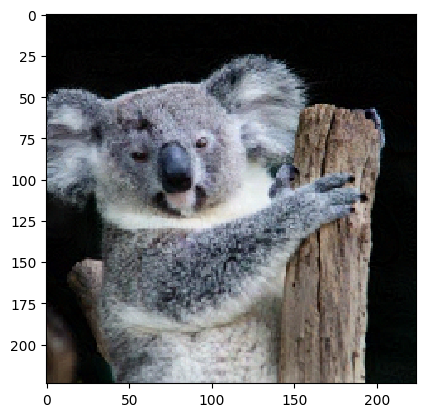

Image classified as: tractor


In [120]:
# Attackutförande
X = np.array([init_image])
y = np.array([866])
print(X.shape)
print(y.shape)
adv_array = FGM.generate(x=X, y=y)

STEPS = 50

for step in range(STEPS):
    if step % 10 == 0:
        print(f"Iter: {step}")
    adv_array = FGM.generate(x=np.array([adv_array[0]]), y=y)
adv_image = im.fromarray(adv_array[0].astype(np.uint8))
adv_class_id = np.argmax(model.predict(adv_array))

plt.imshow(adv_array[0].astype(np.uint8), interpolation='nearest')
plt.show()
print(f"Image classified as: {class_lookup[adv_class_id]}")

(1, 224, 224, 3)
(1,)
Iter: 0
Iter: 10
Iter: 20
Iter: 30
Iter: 40


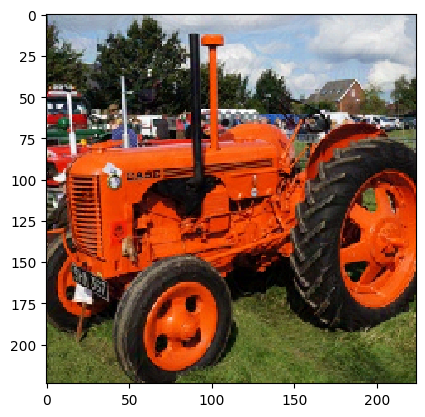

Image classified as: koala


In [121]:
# Attackutförande
X= np.array([target_image])
y = np.array([105])
print(X.shape)
print(y.shape)
adv_array = FGM.generate(x=X, y=y)
STEPS = 50

for step in range(STEPS):
    if step % 10 == 0:
        print(f"Iter: {step}")
    adv_array = FGM.generate(x=np.array([adv_array[0]]), y=y)
adv_image = im.fromarray(adv_array[0].astype(np.uint8))

adv_class_id = np.argmax(model.predict(adv_array))

plt.imshow(adv_array[0].astype(np.uint8), interpolation='nearest')
plt.show()
print(f"Image classified as: {class_lookup[adv_class_id]}")

### Attackresultat

Summera och förklara era attackresultat i flytande text här

In [ ]:
# Presentera attackens resultat m.h.a. kod här

## Skyddsåtgärder

Beskriv (i rapportens sektion 2.3) vilka säkerhetsåtgärd(er) ni valt som lämpliga för att skydda mot er attack. Motivera varför ni valt just de(n) metod(erna).

## Implementation av skyddsåtgärder (frivilligt endast för A eller B)

Nedan fyller ni i er kod som implementerar skyddsmekanismen mot er attackmetod. Skriv även en summering av vad skyddsresultatet blev när ni implementerade metoden (beskriv detta i rapportens del 2.4).

### Egna funktioner

In [ ]:
# Samla era egna funktioner relaterade till säkerhetsåtgärden här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil

### Förberedelser

In [ ]:
# E.g. skapande av ny modell, etc.

### Skydd

Beskriv säkerhetsåtgärden kortfattat här

(1, 224, 224, 3)
(1,)
Iter: 0
Iter: 10
Iter: 20
Iter: 30
Iter: 40


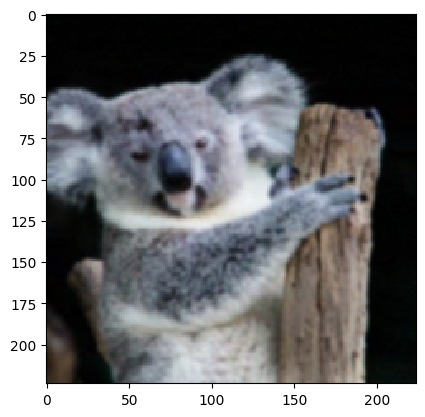

Image classified as: koala


In [134]:
# Implementation av skyddsåtgärd

from PIL import Image, ImageFilter

X = np.array([init_image])
y = np.array([866])
print(X.shape)
print(y.shape)
adv_array = FGM.generate(x=X, y=y)

STEPS = 50

for step in range(STEPS):
    if step % 10 == 0:
        print(f"Iter: {step}")
    adv_array = FGM.generate(x=np.array([adv_array[0]]), y=y)
adv_image = im.fromarray(adv_array[0].astype(np.uint8))


# BLUR DEFENSE
adv_image = adv_image.filter(ImageFilter.GaussianBlur(1))
adv_array = np.array([image.img_to_array(adv_image)])
adv_class_id = np.argmax(model.predict(adv_array))

plt.imshow(adv_array[0].astype(np.uint8), interpolation='nearest')
plt.show()
print(f"Image classified as: {class_lookup[adv_class_id]}")

### Skyddsresultat

Bevisa och förklara era skyddsresultat i flytande text här

In [ ]:
# Presentera skyddåtgärdens resultat m.h.a. kod här

# Referenser

Lista era referenser här. E.g. var ni hittat information om attacken, skyddsåtgärder eller bibliotekets dokumentation/repository.